<a href="https://colab.research.google.com/github/TatyanaPythonista/russian_salary/blob/main/russian_salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict salary in Russia**

**Task:**

Analyze the data, select the optimal predictive model for them in the ARIMA class, and build a forecast for each month two years ahead from the end of the data.

Import libraries:

In [ ]:
pip install python-dateutil

In [188]:
from google.colab import files
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats
from itertools import product

import datetime
from dateutil.relativedelta import *

Create function

In [189]:
def invboxcox(y, lmbda):
  if lmbda == 0:
    return np.exp(y)
  else:
    return np.exp(np.log(lmbda*y+1)/lmbda)

Upload file with data

In [15]:
files.upload()

{}

In [197]:
salary = pd.read_csv('WAG_C_M.csv', sep=';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [199]:
salary.index = pd.to_datetime(salary.index)


Let's look at data frame

In [200]:
salary

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
...,...
2016-04-01,36497.0
2016-05-01,37270.0
2016-06-01,38447.0


Create a line graph

[Text(0, 0.5, 'salary'), Text(0.5, 0, 'years')]

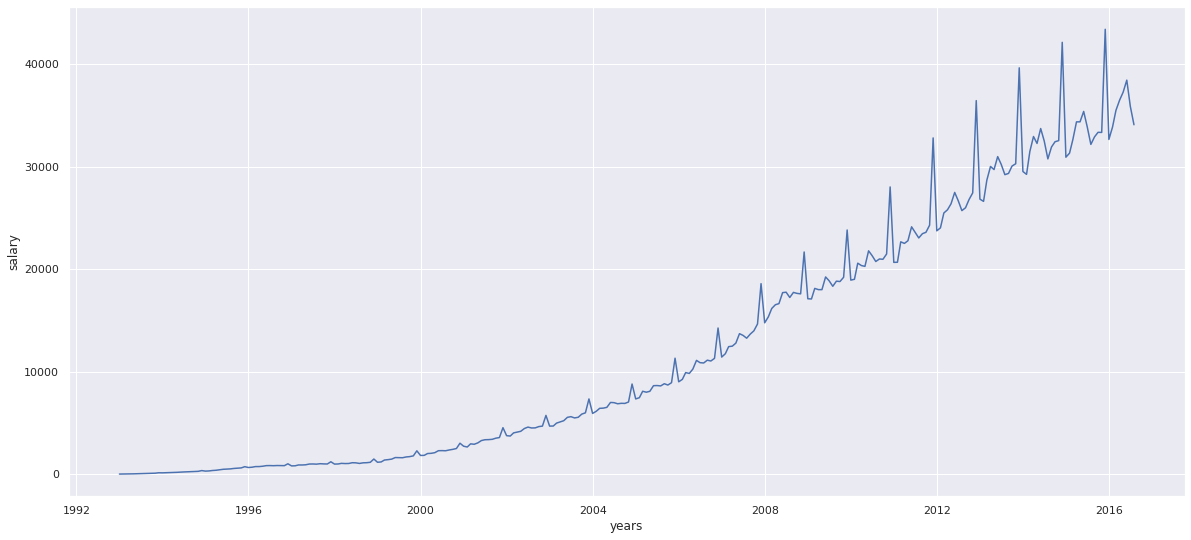

In [201]:
sns.set(rc={'figure.figsize':(20, 9)})
ax = sns.lineplot(x="month", y="WAG_C_M", data=salary)
ax.set(xlabel='years', ylabel='salary')

Stationarity check and STL-decomposition of series



In [202]:
print(f'Dickey—Fuller test: {sm.tsa.stattools.adfuller(salary.WAG_C_M)[1]}')

Критерий Дике-Фуллера: 0.9918495954854735


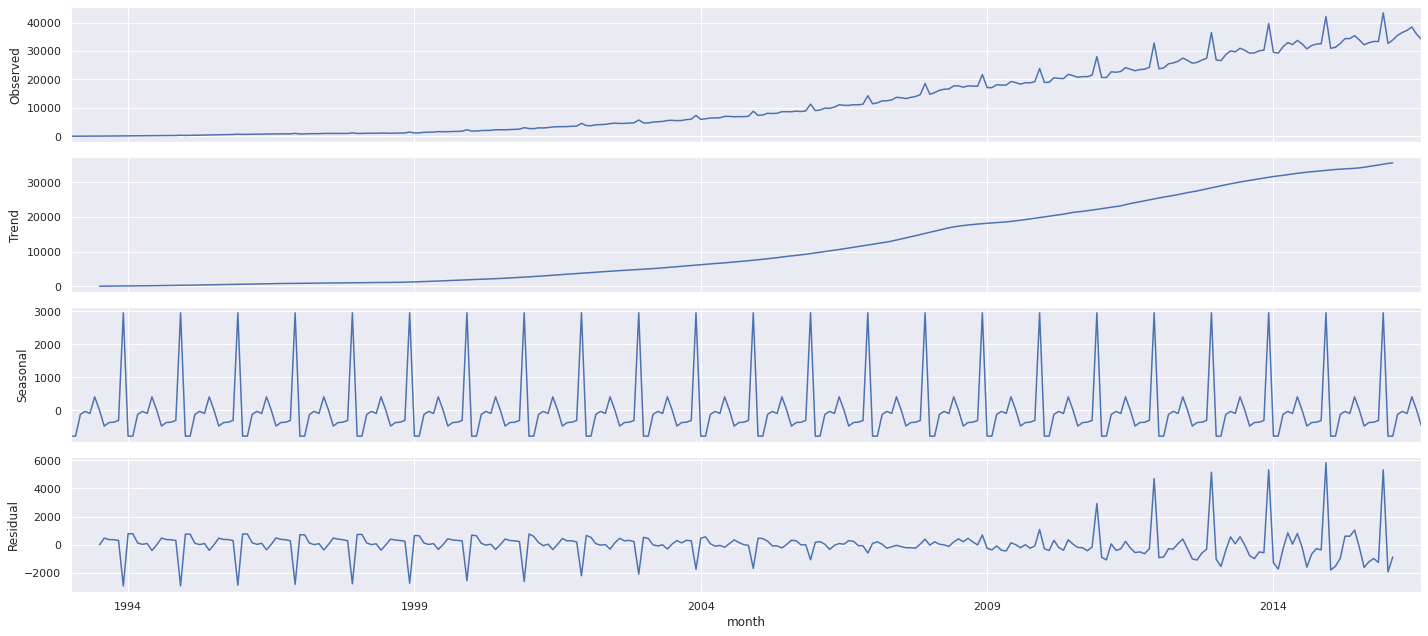

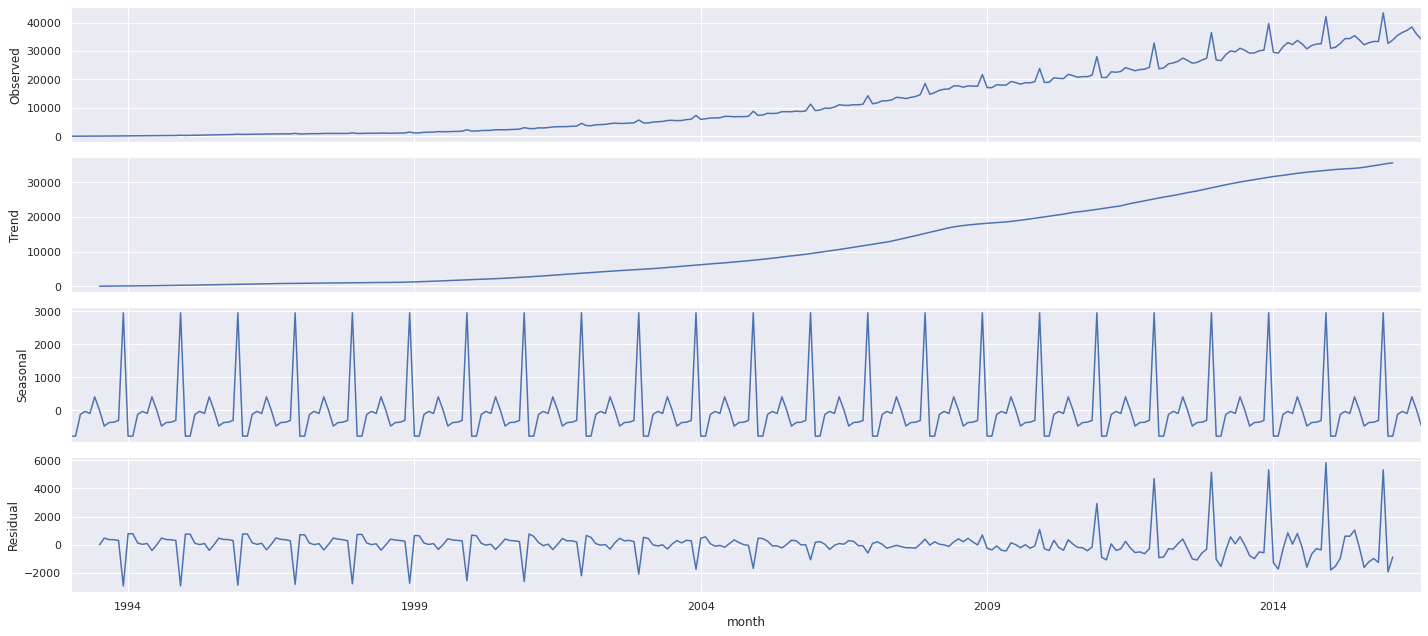

In [203]:
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()

**Dispersion stabilization**

Let's make the Box-Cox transformation to stabilize dispersion

In [204]:
salary['WAG_C_M_boxcox'], lmbda = stats.boxcox(salary.WAG_C_M)

In [205]:
print(f'Optimal Parameter of Box-Cox Transformation {lmbda}')
print(f'Dickey—Fuller test {sm.tsa.stattools.adfuller(salary.WAG_C_M_boxcox)[1]}')

Оптимальный параметр преобразования Бокса-Кокса 0.2632017541844584
Критерий Дики-Фуллера 0.6968987634832653


Lets look at line graph after dispersion stabilization

[Text(0, 0.5, 'sales_boxcox'), Text(0.5, 0, 'years')]

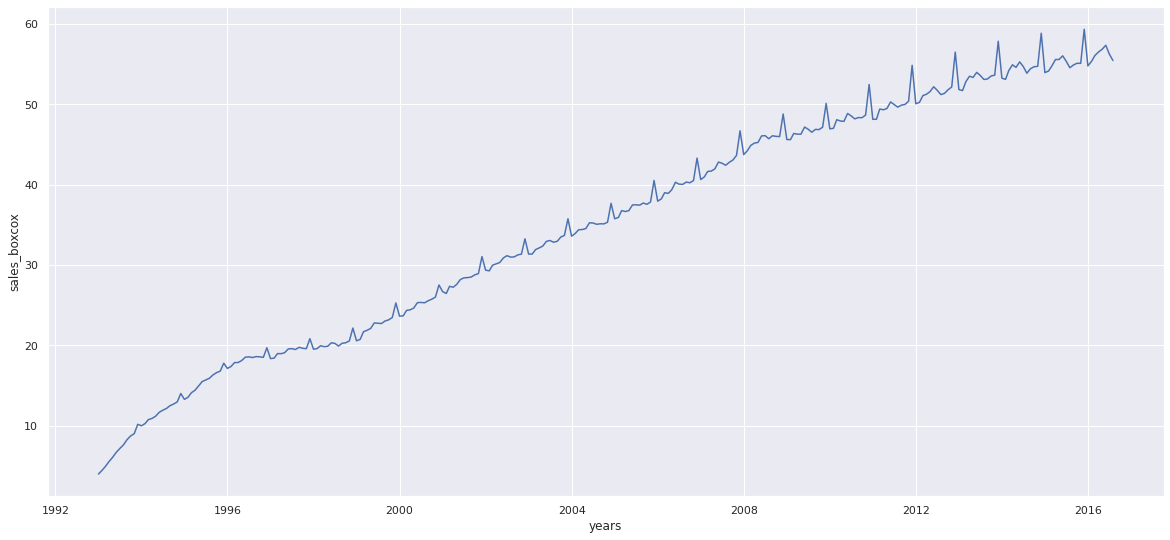

In [206]:
sns.set(rc={'figure.figsize':(20, 9)})
ax = sns.lineplot(x="month", y="WAG_C_M_boxcox", data=salary)
ax.set(xlabel='years', ylabel='sales_boxcox')

STL-decomposition of series after dispersion stabilization

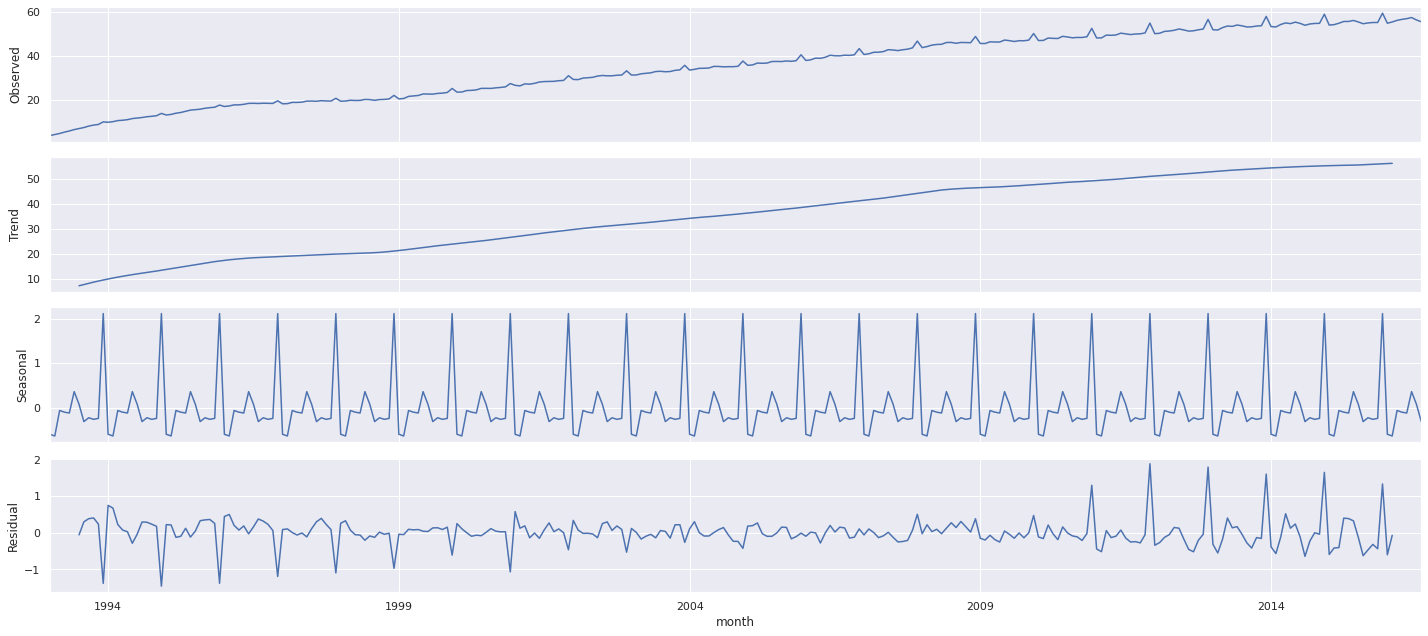

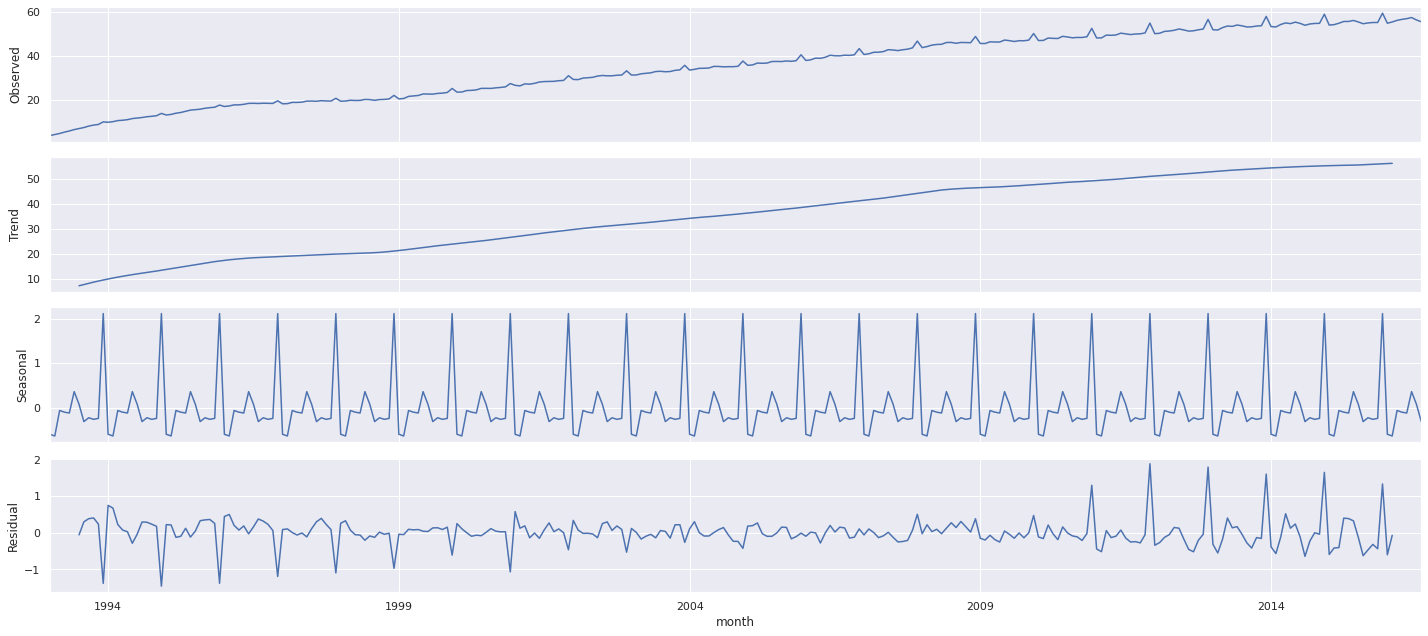

In [207]:
sm.tsa.seasonal_decompose(salary.WAG_C_M_boxcox).plot()

**Stationarity**

Make seasonal differencing

In [208]:
salary['WAG_C_M_boxcox_diff'] = salary.WAG_C_M_boxcox - salary.WAG_C_M_boxcox.shift(12)

In [209]:
salary.dropna(inplace=True)

In [210]:
salary.head(2)

,WAG_C_M,WAG_C_M_boxcox,WAG_C_M_boxcox_diff
month,,,
1994-01-01,134.2,9.996196,6.005802
1994-02-01,144.7,10.272455,5.813697


Look at Dickey—Fuller test and STL-decomposition of series after seasonal differencing

In [211]:
print(f'Dickey—Fuller test {sm.tsa.stattools.adfuller(salary.WAG_C_M_boxcox_diff)[1]}')

Критерий Дики-Фуллера 0.014697133494791808


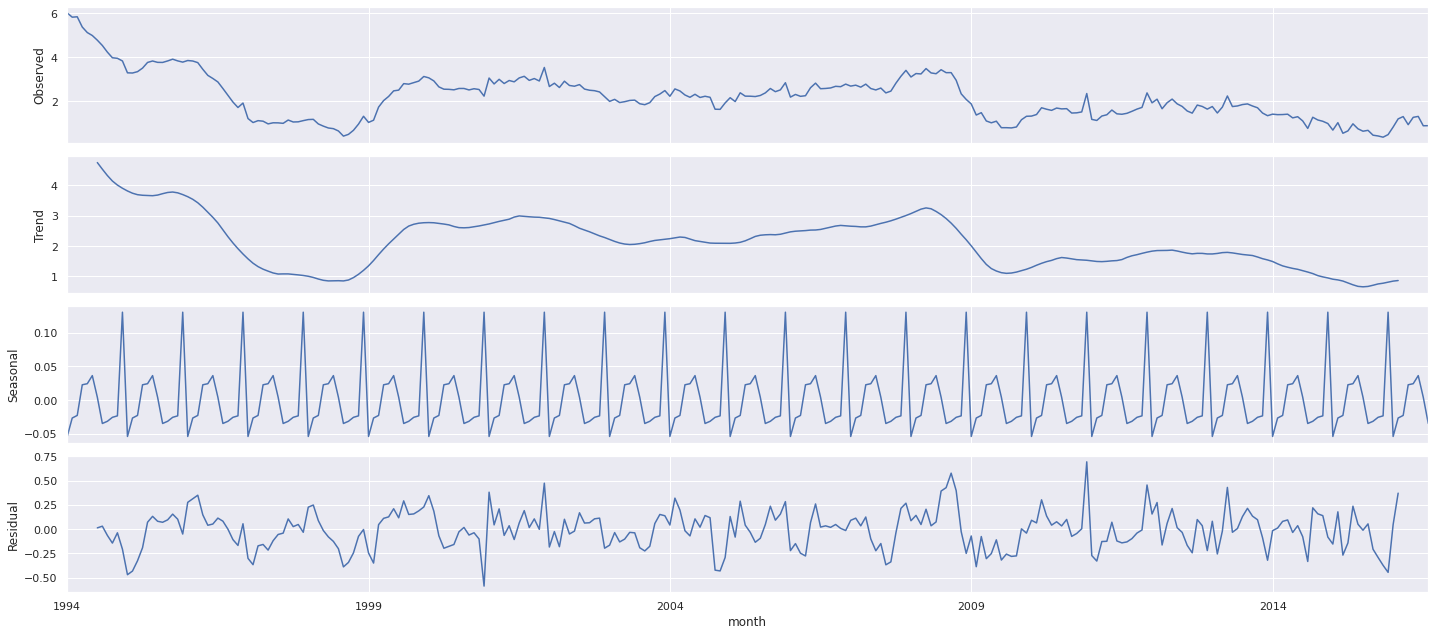

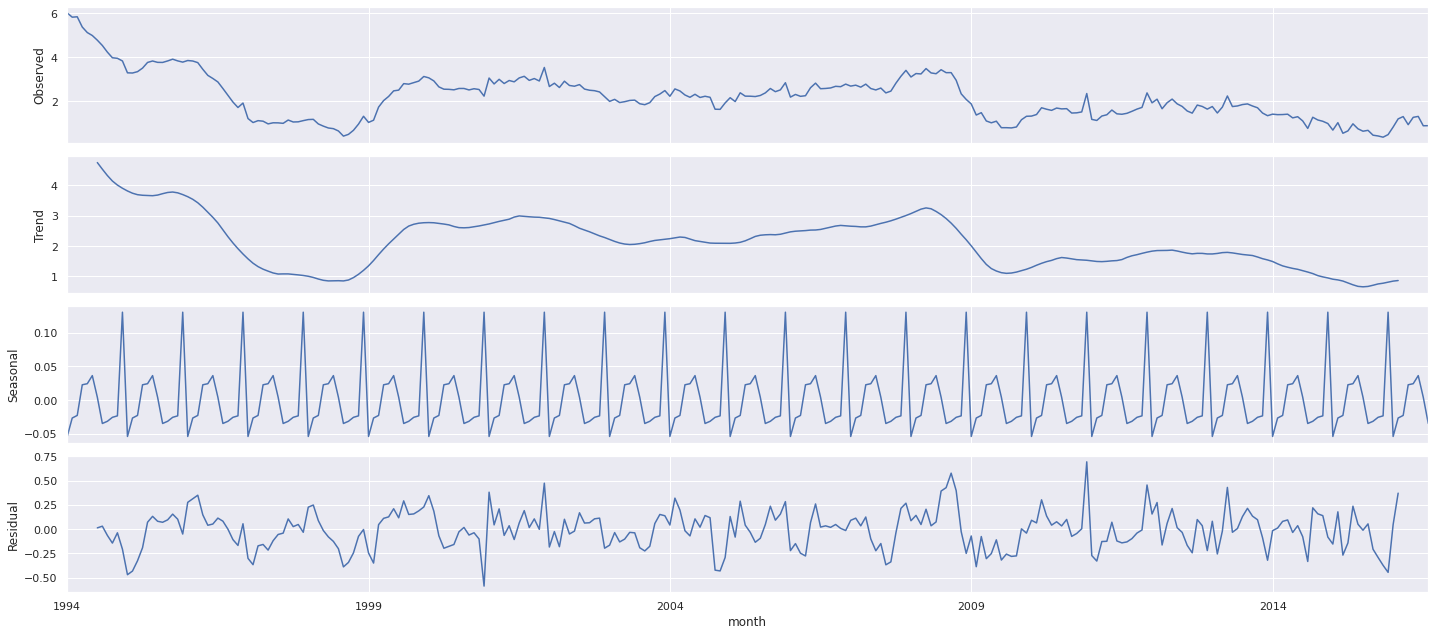

In [212]:
sm.tsa.seasonal_decompose(salary.WAG_C_M_boxcox_diff).plot()

Look at Dickey—Fuller test and STL-decomposition of series after differencing

Критерий Дики-Фуллера: p=5.203603715821631e-08


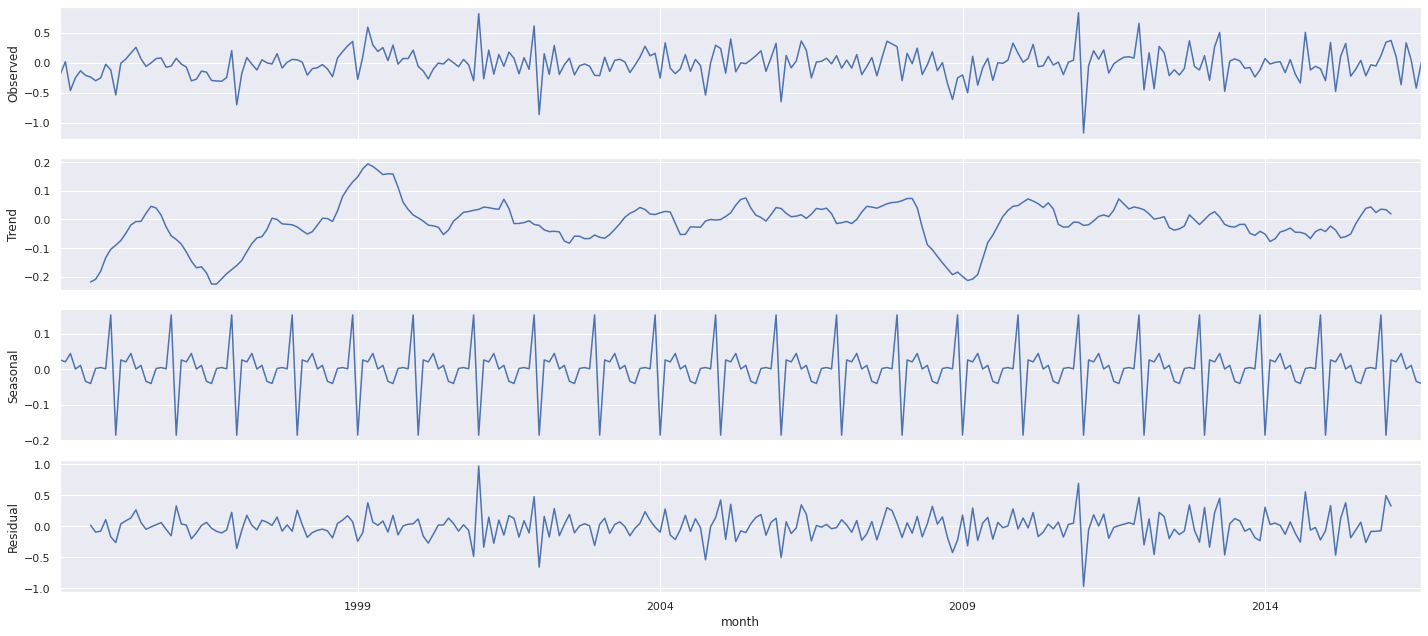

In [213]:
salary['WAG_C_M_boxcox_diff2'] = salary.WAG_C_M_boxcox_diff - salary.WAG_C_M_boxcox_diff.shift(1)
salary.dropna(inplace=True)
sm.tsa.seasonal_decompose(salary.WAG_C_M_boxcox_diff2).plot()   
print(f'Dickey—Fuller test: p={sm.tsa.stattools.adfuller(salary.WAG_C_M_boxcox_diff2)[1]}')

**Model selection**

Let's look at the ACF and PACF of the resulting series

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


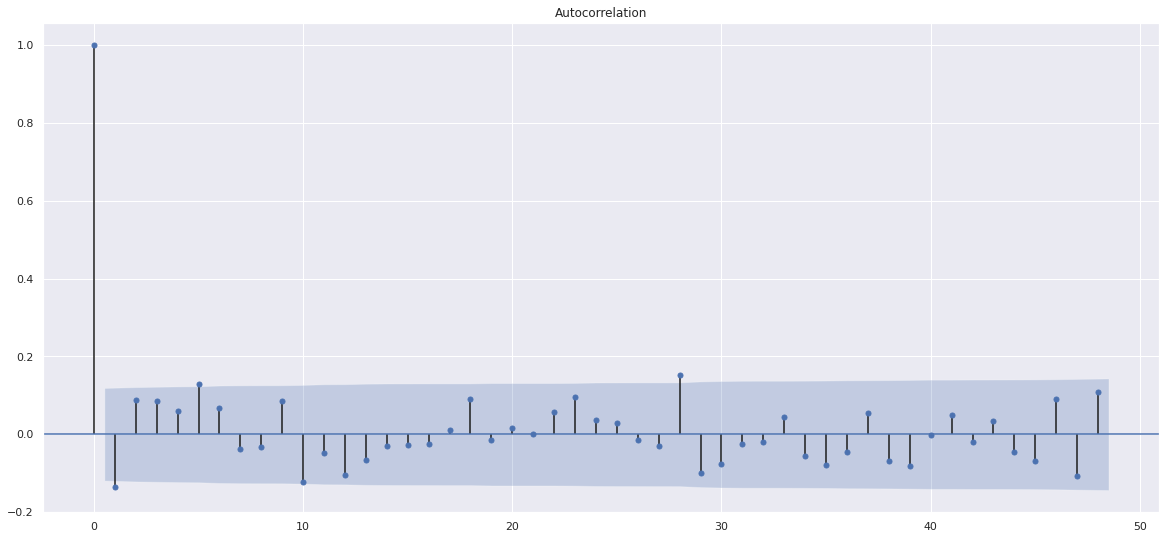

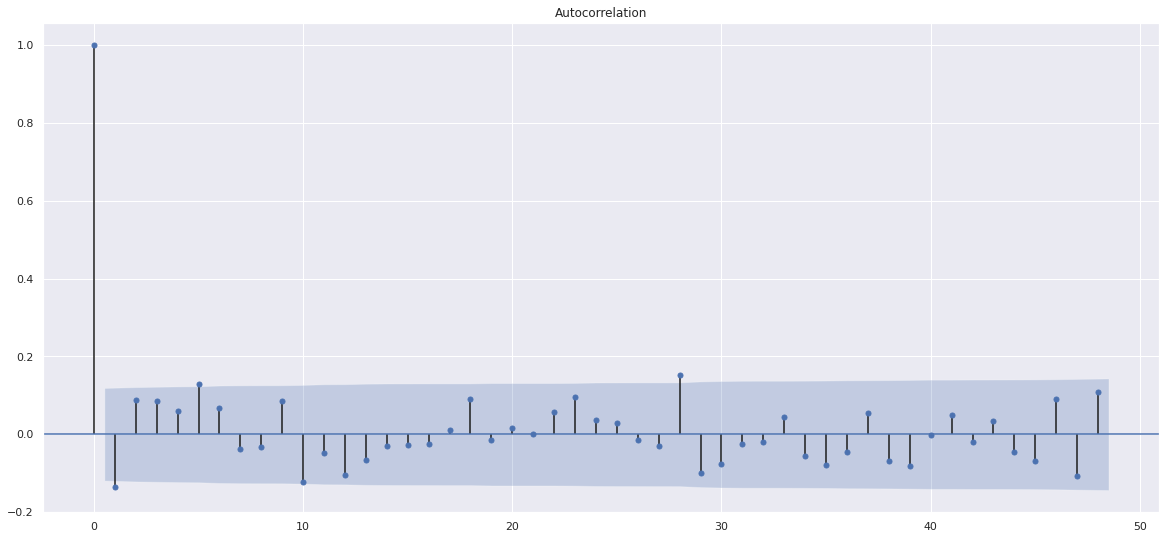

In [214]:
sm.graphics.tsa.plot_acf(salary.WAG_C_M_boxcox_diff2.values.squeeze(), lags=48)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


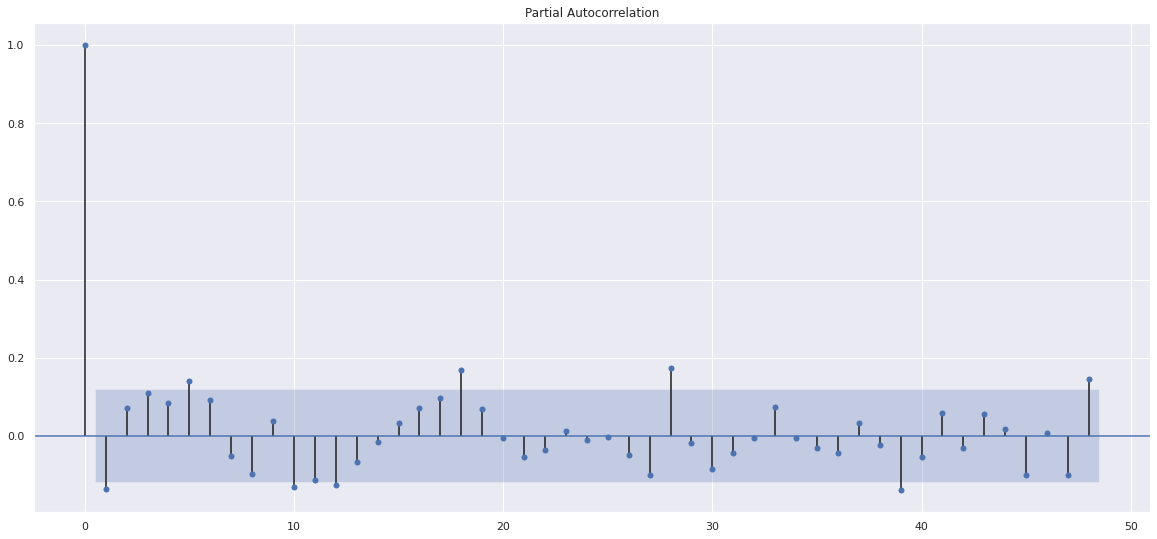

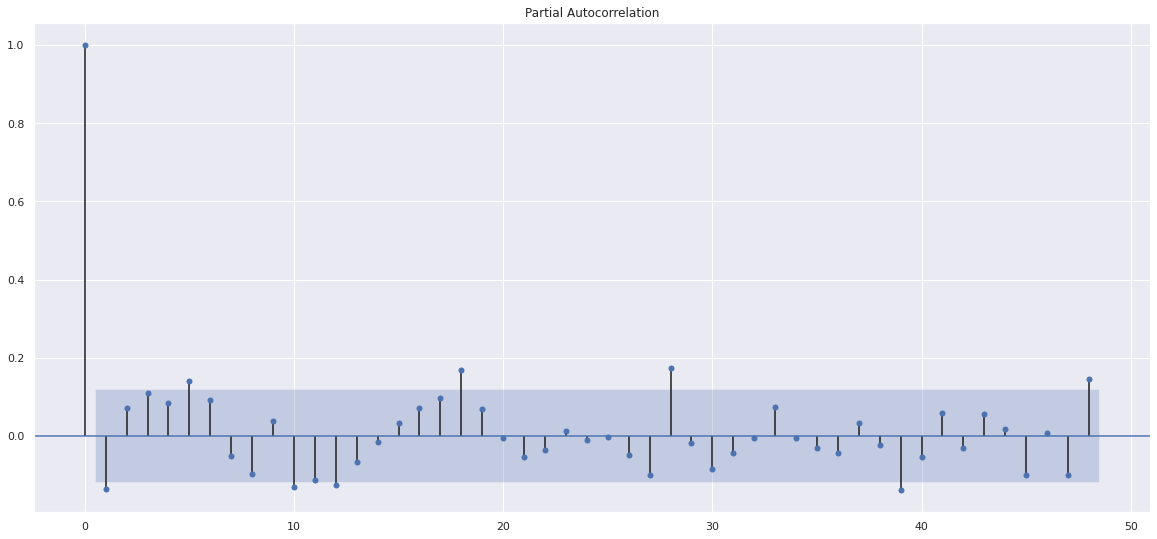

In [215]:
sm.graphics.tsa.plot_pacf(salary.WAG_C_M_boxcox_diff2.values.squeeze(), lags=48)

Initial approximation Q=0, q=1, P=4, p=11

In [130]:
d = 1
D = 1
Q = 0
qs = range(0, 2)
Ps = range(0, 5)
ps = range(0, 11)

In [131]:
parametrs = product(ps, qs, Ps)
parametrs_list = list(parametrs)
len(parametrs_list)

110

Find the best model

In [216]:
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parametrs_list:
  try:
    model = sm.tsa.statespace.SARIMAX(salary.WAG_C_M_boxcox, order=(param[0], d, param[1]),
                                      seasonal_order=(param[2], D, Q, 12)).fit(disp=-1)
  except Exception:
    print(f'Wrong parameters: {param}')
    continue
  aic = model.aic
  if aic < best_aic:
    best_model = model
    best_aic = aic
    best_param = param
  results.append([param, model.aic])

warnings.filterwarnings('default')

In [217]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters       aic
76    (7, 1, 1) -9.083924
106  (10, 1, 1) -7.629553
75    (7, 1, 0) -7.555063
61    (6, 0, 1) -7.295339
77    (7, 1, 2) -7.149327


In [218]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  271
Model:             SARIMAX(7, 1, 1)x(1, 1, 0, 12)   Log Likelihood                  14.542
Date:                            Thu, 10 Mar 2022   AIC                             -9.084
Time:                                    07:52:31   BIC                             26.446
Sample:                                02-01-1994   HQIC                             5.203
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7412      0.055     13.403      0.000       0.633       0.850
ar.L2          0.2225      0.081   

Look at residuals

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lags = lags.astype(np.float)


Критерий Стьюдента: p=0.150545
Критерий Дики-Фуллера: p=0.000000


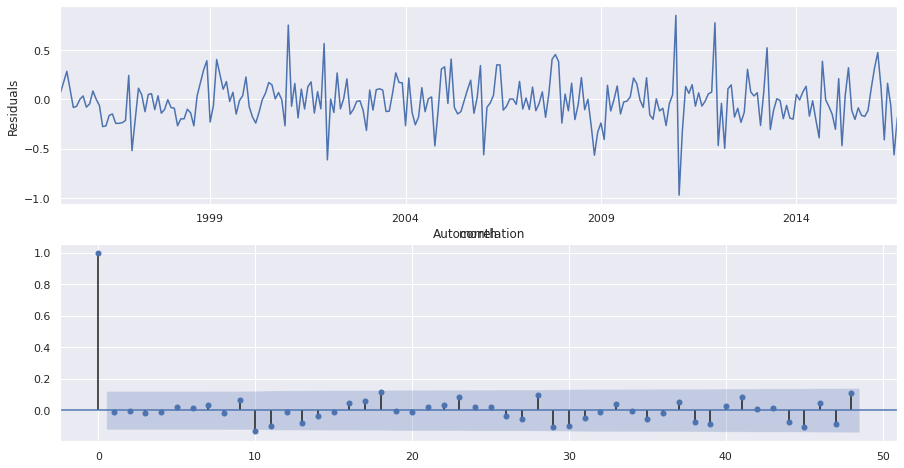

In [219]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("t-test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey—Fuller test: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Look at our model and compare it with original

Text(0, 0.5, 'sales')

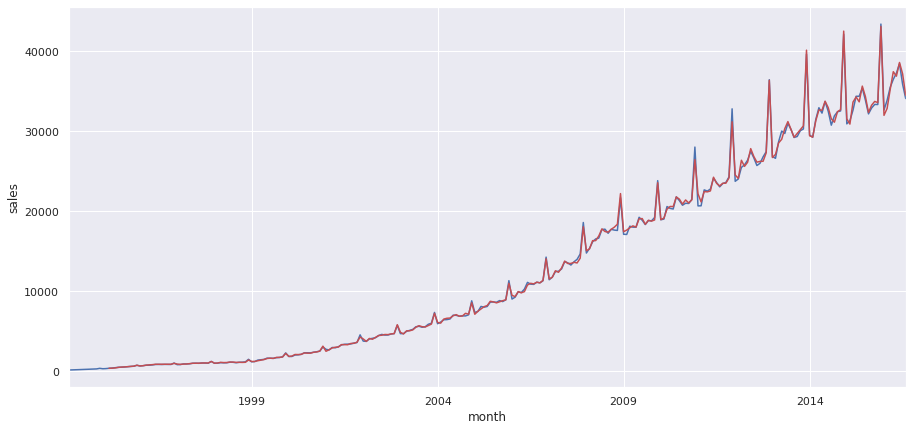

In [220]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('salary')

**Prediction**

Text(0, 0.5, 'Salary')

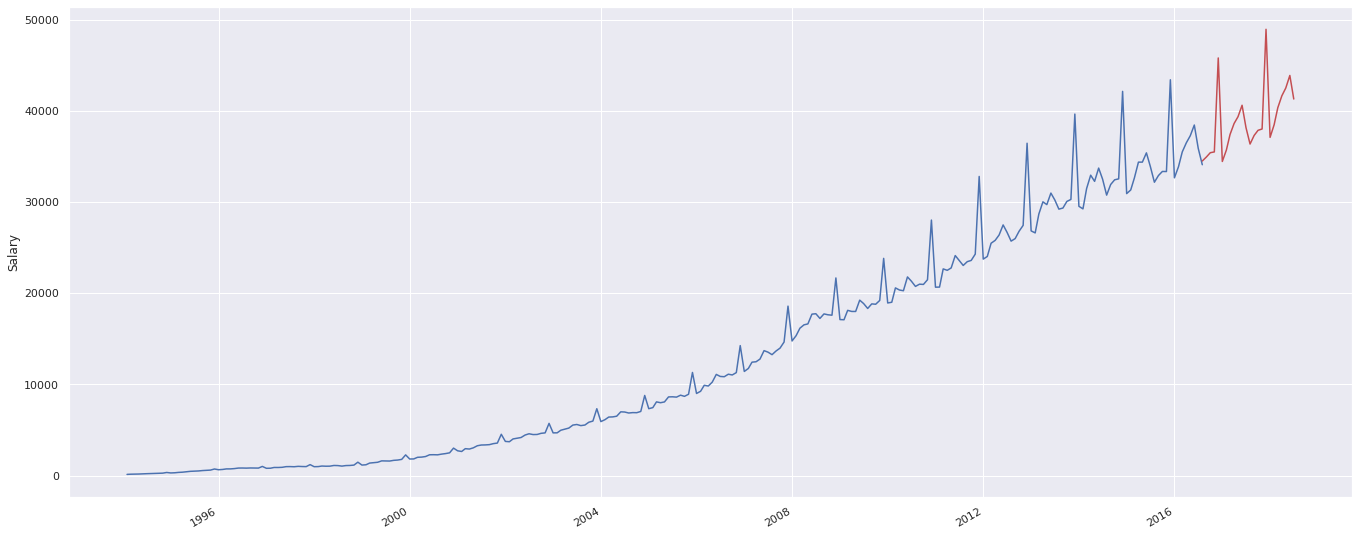

In [223]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime('2016-08-01', '%Y-%m-%d') + relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(index=date_list, columns=salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=270, end=330), lmbda)

plt.figure(figsize=(23, 10))
salary2.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')